# Aggregation of Power System Optimization Models - Part III

Now applying the Basis-Oriented approach considering network constraints

In [9]:
from importlib import reload

import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import testbed_network as testbed

import warnings
reload(testbed)
warnings.filterwarnings(action='ignore')

In [10]:
# We can export the variables, first create a folder and then export the results
slvr = 'gurobi'     # change according to the solver installed in your machine

results_complete = testbed.run_complete_case(folder='data', case='complete_network.xlsx', solver='gurobi')
df_duals = testbed.extract_duals(results_complete, 'complete_network_ext')
df_complete, df_hourly = testbed.export_complete_solution(results_complete, 'complete_network_ext')

marginal_costs = df_duals.drop(columns=['period']).drop_duplicates()['eBalance_bus_1']
marginal_costs

0        24.1
3         3.2
4         3.1
20       24.1
59     5000.0
60     5000.0
216      24.1
619    5000.0
Name: eBalance_bus_1, dtype: float64

### Grouping the Hours
Now let's group together the hours with the same duals vector

In [11]:
# this is not the best way, but a quick and dirty one
df_cf = pd.read_excel(os.path.join('data', 'complete_network.xlsx'), sheet_name='cap_factors')
df_demand = pd.read_excel(os.path.join('data', 'complete_network.xlsx'), sheet_name='demand')
df_input = pd.merge(left=df_demand, left_on='period', right=df_cf, right_on='period')

i = 1
df_input_copy = df_input.copy()
df_input_copy['basis'] = ''
df_input_copy['weight'] = 0
basis_w = []
basis = df_duals.iloc[:, 1:].drop_duplicates().reset_index(drop=True)
df_duals_aux = df_duals.drop(columns='period')
for idx, r in basis.iterrows():
    idx_basis = testbed.idx_match(r, df_duals_aux)
    df_input_copy.loc[idx_basis, 'basis'] = i
    df_input_copy.loc[idx_basis, 'weight'] = len(idx_basis)
    i = i + 1


### Centroid Calculation
For each of these groups, calculate a centroid

In [12]:
df_basis_centroids = df_input_copy.groupby('basis').agg(
    {'cap_factor': ['mean'], 'demand': ['mean'], 'weight': ['max']})
df_basis_centroids.reset_index(drop=False, inplace=True)  # to have the week as a data column and not as index
df_basis_centroids.columns = ['_'.join(col) for col in df_basis_centroids.columns]
df_basis_centroids = df_basis_centroids.rename(
    columns={'cap_factor_mean': 'cap_factor', 'demand_mean': 'demand', 'weight_max': 'weight'}).drop(
    columns=['basis_'])

### Aggregated Model
Create an aggregated model using the centroids, in this case the weights are the number of hours that correspond to that set of duals

In [13]:
df_config_ext = testbed.generate_config(df_basis_centroids, folder='aggregated_network_ext')
df_basis_centroids

,cap_factor,demand,weight
0,0.509363,499.893278,2088
1,0.717130,253.911291,669
2,0.443705,99.115016,251
3,0.893854,610.493029,397
4,0.435070,776.510841,142
5,0.111295,643.566720,1359
6,0.122998,335.321377,3829
7,0.950000,915.560518,1


### Running the Models
Now is time to run the aggregated and compare its results with the complete one

In [14]:
results = testbed.basis_execution(folder=os.path.join('data', 'aggregated_network_ext'),
                                  # location of the aggregated model
                                  solver='gurobi',
                                  file='config_auto.xlsx')  # configuration file with aggregation information
df_agg_ext = testbed.export_aggregated_solution(results, 'aggregated_network_ext')
df_comparison_ext = testbed.export_model_comparison(df_complete, df_agg_ext)
df_comparison_ext


,result,complete,aggregated,delta,rel_delta
0,of_value,7.009273e+08,7.009273e+08,-1.430511e-06,-1.998401e-15
1,thermal,2.395033e+06,2.395033e+06,6.519258e-09,2.775558e-15
2,renewable,1.227715e+06,1.227715e+06,-6.984919e-10,-6.661338e-16
3,nsp,1.278723e+05,1.278723e+05,-7.275958e-11,-6.661338e-16
4,1_to_1,0.000000e+00,NaN,NaN,NaN
5,1_to_2,0.000000e+00,NaN,NaN,NaN
6,1_to_3,0.000000e+00,NaN,NaN,NaN
7,2_to_1,2.792215e+06,NaN,NaN,NaN
8,2_to_2,0.000000e+00,NaN,NaN,NaN
9,2_to_3,0.000000e+00,NaN,NaN,NaN


## How does that solution look in the input space?

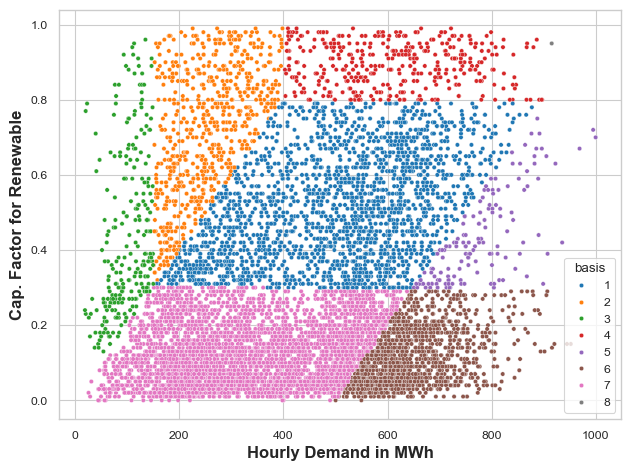

In [15]:
sns.set_style(style='whitegrid')
sns.set_context(context='paper')
df_input_copy_b4 = df_input_copy.copy()
df_input_copy['basis'] = df_input_copy['basis'].astype('category')
ax = sns.scatterplot(df_input_copy, x='demand', y='cap_factor', hue=df_input_copy['basis'], s=10)
ax.set_ylabel('Cap. Factor for Renewable', fontdict={'weight':'bold', 'fontsize': 12})
ax.set_xlabel('Hourly Demand in MWh', fontdict={'weight': 'bold', 'fontsize': 12})
plt.tight_layout()
plt.show()

df_input_copy.to_excel('data_basis.xlsx', index=False)